In [1]:
# Package Imports
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

from importlib import reload

%matplotlib widget

# Importing my modules
from src import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

In [3]:
%store -r line_gdf
%store -r height_gdf

In [111]:
reload(mechanical_computations)

<module 'src.mechanical_computations' from '/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/mechanical_computations.py'>

In [112]:
sample_line = line_gdf.iloc[1].geometry
sample_cable_road = cable_road_computation.compute_initial_cable_road(sample_line,height_gdf)
sample_cable_road.s_current_tension = 3000
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)

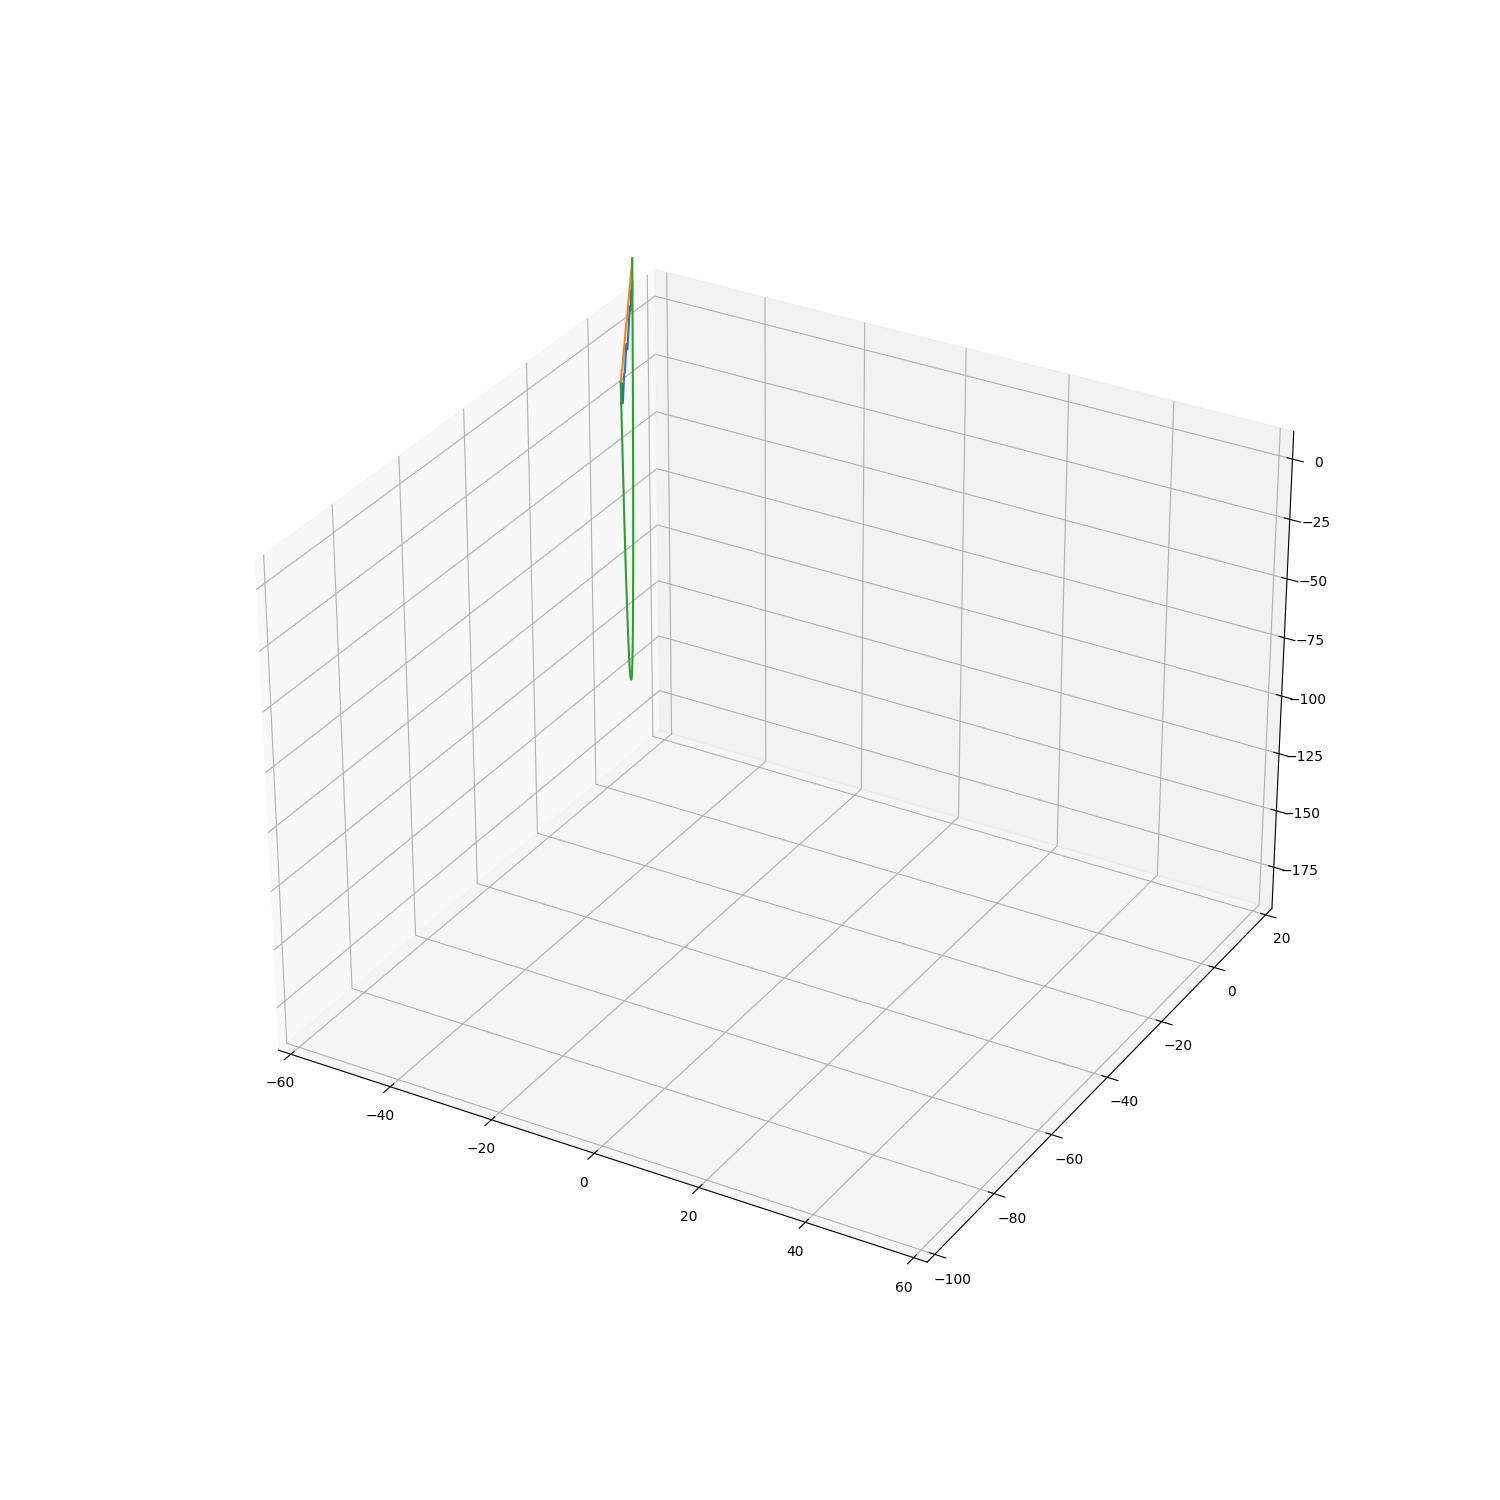

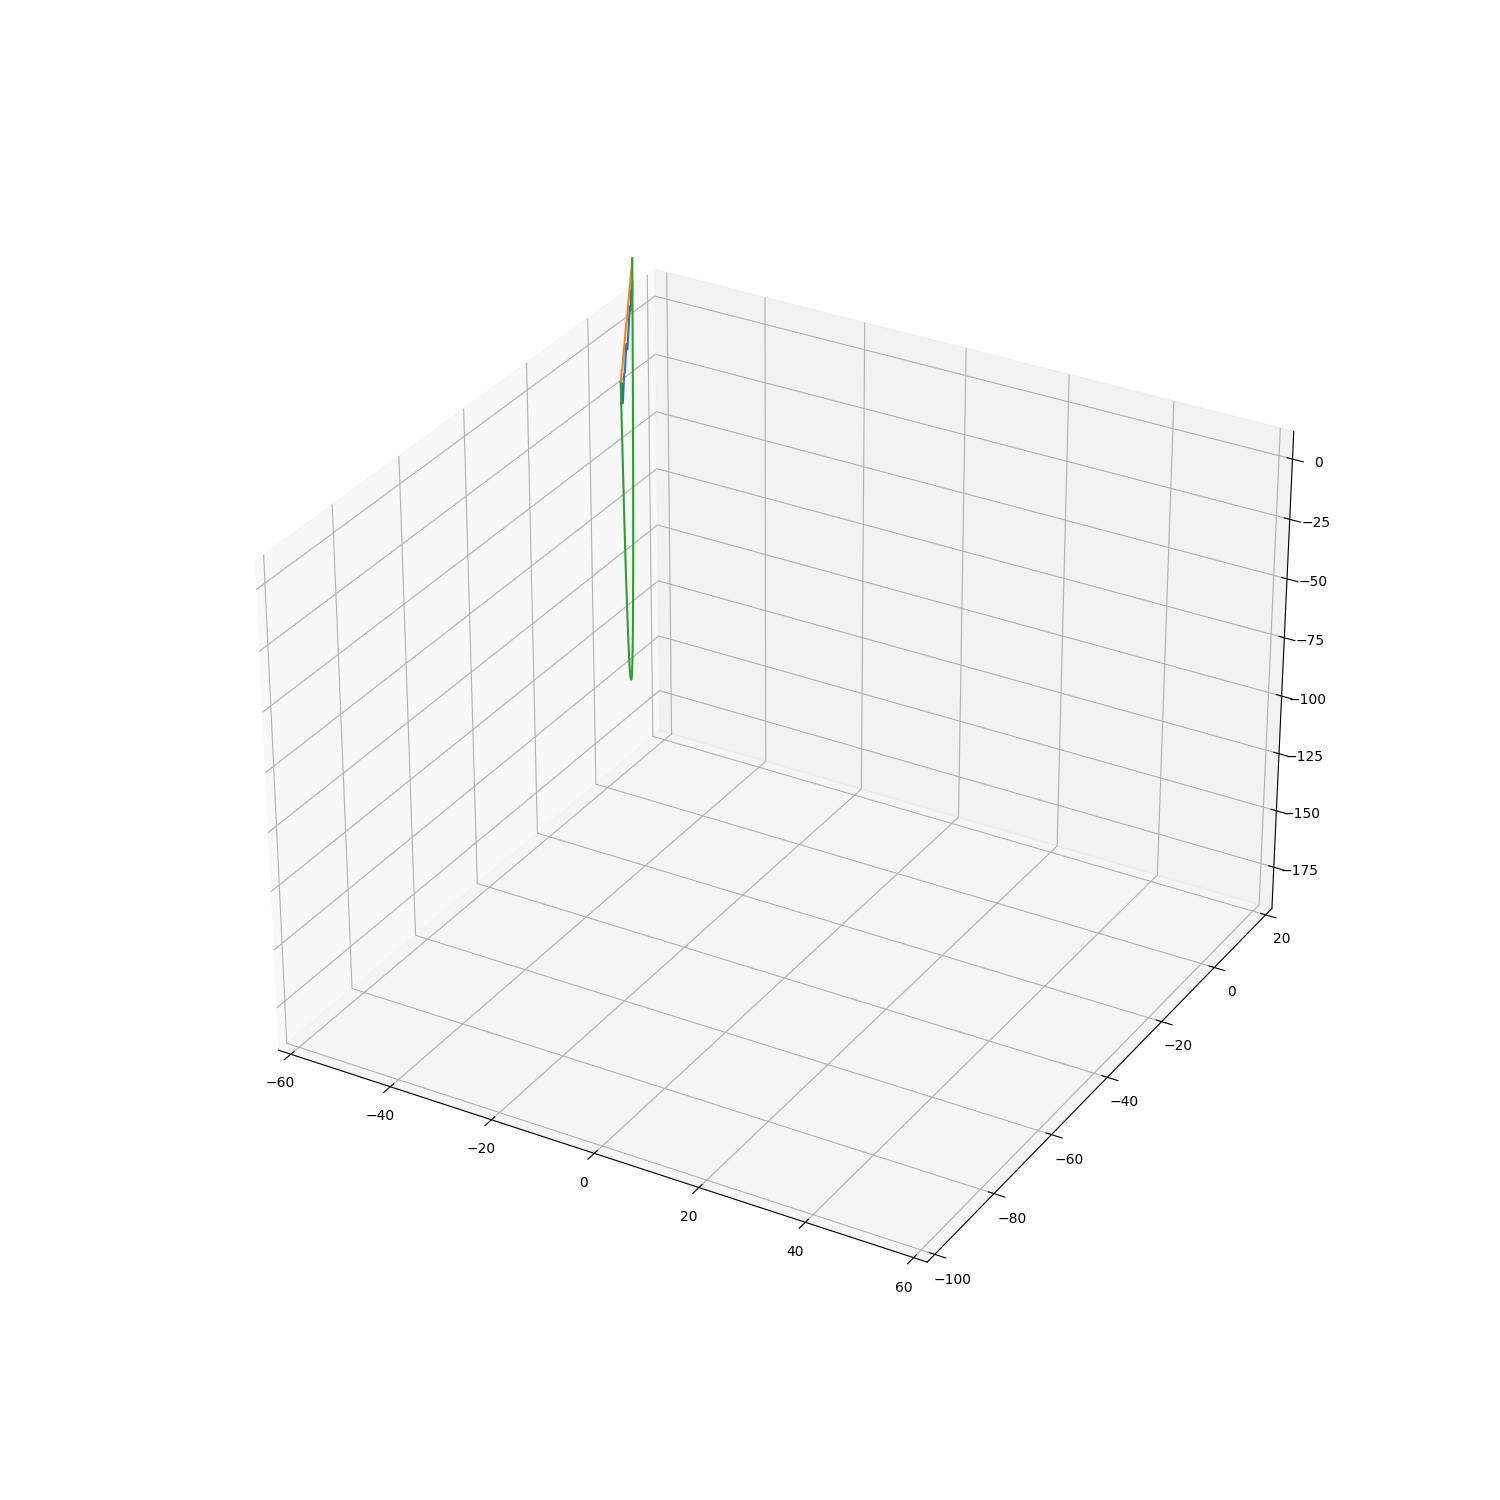

In [113]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d') 
plt.axis([-60,60,-100,20])
ax.plot3D([point[0] for point in sample_cable_road.floor_points],[point[1] for point in sample_cable_road.floor_points], sample_cable_road.floor_height_below_line_points)
ax.plot3D([point[0] for point in sample_cable_road.floor_points],[point[1] for point in sample_cable_road.floor_points], sample_cable_road.floor_height_below_line_points+sample_cable_road.line_to_floor_distances)
ax.plot3D([point[0] for point in sample_cable_road.floor_points],[point[1] for point in sample_cable_road.floor_points], sample_cable_road.floor_height_below_line_points+sample_cable_road.sloped_line_to_floor_distances)
fig.show()

/tmp/ipykernel_332275/4188036756.py:10: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(xmin, xmax, nx)


interactive(children=(FloatSlider(value=1000.0, description='force', max=10000.0, min=1000.0, step=100.0), Out…

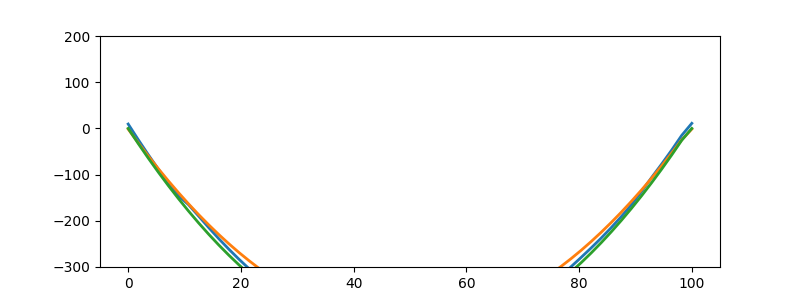

In [114]:
from ipywidgets import interact, FloatSlider
from scipy import linspace

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.set_ylim([-300, 200])

xmin, xmax, nx = 0.0, 100.0, 57
ymin, ymax     = -1.2, 1.2
x = linspace(xmin, xmax, nx)

sample_cable_road.s_current_tension= 10
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
y = sample_cable_road.sloped_line_to_floor_distances

line, = ax.plot(x, y, linewidth=2)
deflection_direct, = ax.plot(x, y, linewidth=2)
deflection_pestal, = ax.plot(x, y, linewidth=2)

def plot_sloped_line_to_floor(force):
    sample_cable_road.s_current_tension = force
    mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
    y = sample_cable_road.sloped_line_to_floor_distances
    line.set_ydata(y)

    y_x_deflections = np.asarray([
        mechanical_computations.lastdurchhang_at_point(
            sample_cable_road, point
        )
        for point in sample_cable_road.points_along_line
    ])

    y_x_deflections_pestal = np.asarray([
        mechanical_computations.pestal_load_path(
            sample_cable_road, point
        )
        for point in sample_cable_road.points_along_line
    ])

    deflection_direct.set_ydata(-y_x_deflections)
    deflection_pestal.set_ydata(-y_x_deflections_pestal)

    fig.canvas.draw()

interact(plot_sloped_line_to_floor, force=FloatSlider(min=1000, max=10000, step=100, value=10));

#### Checking Geometry of Forces

interactive(children=(FloatSlider(value=10.0, description='force', max=3000.0, step=1.0), FloatSlider(value=10…

<function __main__.plot_load_on_support(force, angle)>

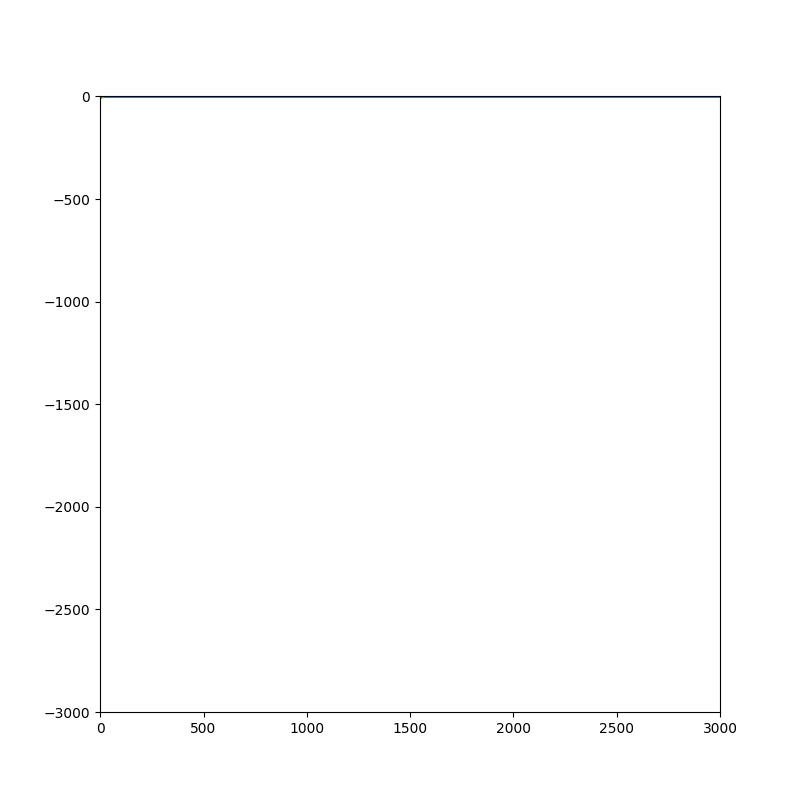

In [108]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_ylim([-3000, 2])   # set the bounds to be 10, 10
ax.set_xlim([-1, 3000]) 
unloaded_tangent_line, = ax.plot([0, 3000], [0, 0], linewidth=2)
loaded_tangent, = ax.plot([0, 1000], [0, -0], linewidth=2)
force_on_support, = ax.plot([0, 0], [0, -10], linewidth=2)

def plot_load_on_support(force, angle):
    loaded_tangent.set_xdata([0, force])

    res = mechanical_computations.parallelverschiebung(force, angle)
    loaded_tangent.set_ydata([0, -res])

    force_on_support.set_xdata([0, 0])
    force_on_support.set_ydata([0, -res])

    fig.canvas.draw()

interact(plot_load_on_support, force=FloatSlider(min=0, max=3000, step=1, value=10), angle=FloatSlider(min=0, max=45, step=1, value=10))

#### Surface Plots of Functions

/tmp/ipykernel_332275/2684807569.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


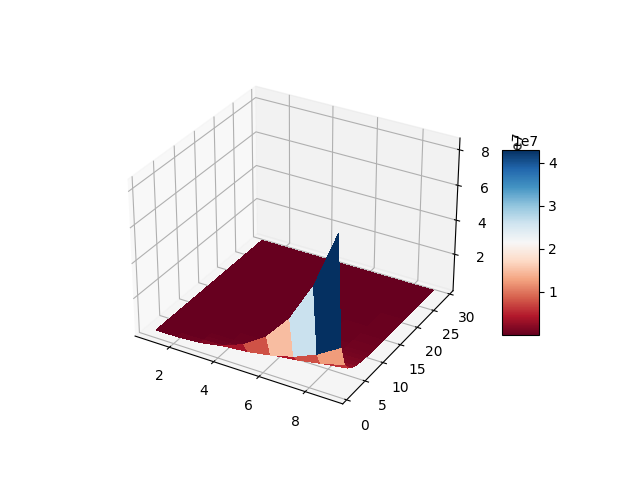

In [12]:
import matplotlib.pyplot as plt
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x = np.arange(1,10,1)
y = np.arange(1,30,1)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.euler_knicklast(X,Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

/tmp/ipykernel_332275/3925539811.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


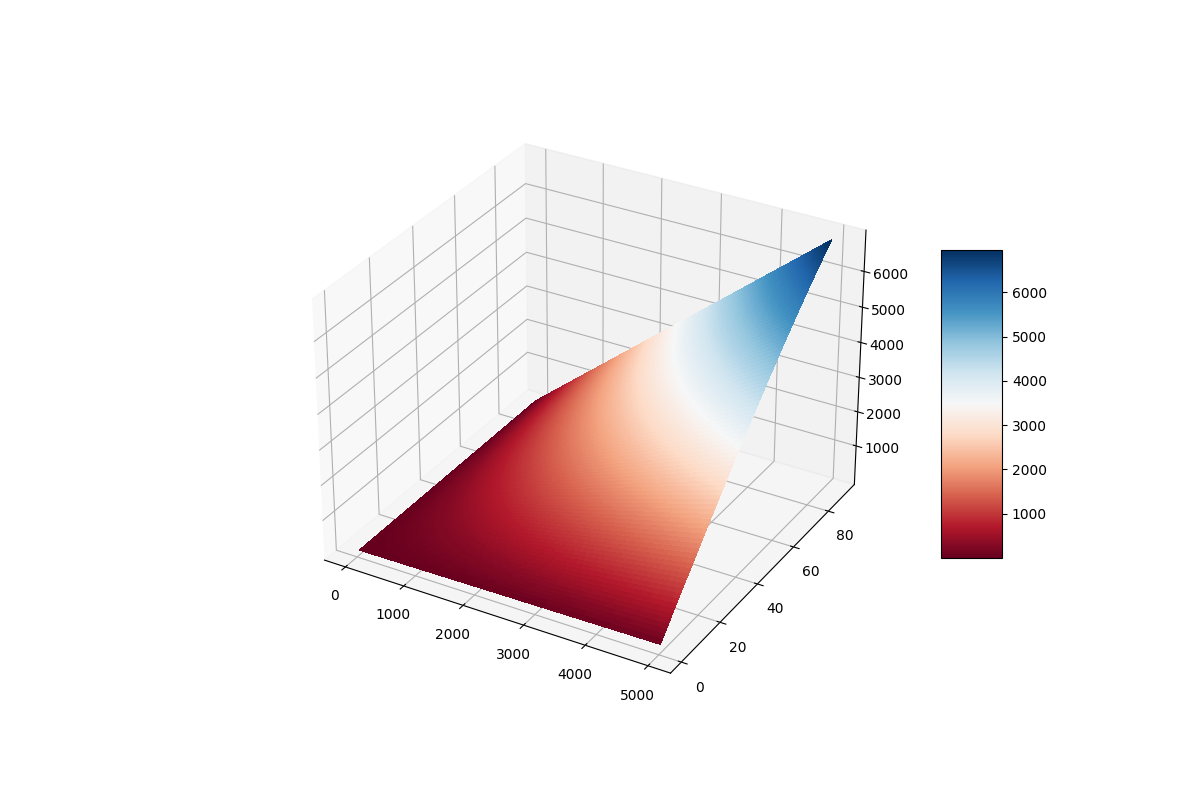

In [19]:
y = np.arange(1,90,1)
x = np.arange(1,5000,10)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.parallelverschiebung(X,Y)

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()